# Group 4 Assignment 2 

### Authors: 
-  Chin Yee Wan 
-  Darrel Koh
-  Nguyen Gia Khanh 
-  Ngo Vu Anh	

### Main Steps
1.  Data Preprocessing 
-   Read in as SPARK dataframe for data preprocessing
-   Convert to Pandas dataframe for data exploration
2.  Data Exploration
3.  Data Modelling
4.  Data Evaluation

# Discover and Visualise the Data

## Import Libraries

In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pylab import rcParams
from imblearn.over_sampling import SMOTE


from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.ml import Pipeline
from pyspark.ml.feature import StandardScaler, VectorAssembler, StringIndexer
from pyspark.ml.classification import RandomForestClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.mllib.evaluation import BinaryClassificationMetrics

from sklearn.metrics import confusion_matrix, classification_report

## Functions definition 

### Read in file

In [2]:
train_df = pd.read_csv('GA2Datasets/UNSW_NB15_training-set.csv')
test_df = pd.read_csv('GA2Datasets/UNSW_NB15_testing-set.csv')

In [3]:
spark = SparkSession.builder \
                            .appName("CSCI316GP2")\
                            .config("spark.sql.files.maxPartitionBytes", "1000000")\
                            .getOrCreate()

23/08/15 16:51:17 WARN Utils: Your hostname, Darrels-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.0.192 instead (on interface en0)
23/08/15 16:51:17 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/08/15 16:51:17 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
spark_df = spark.createDataFrame(train_df)
spark_df.show()

23/08/15 16:51:30 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
23/08/15 16:51:31 WARN TaskSetManager: Stage 0 contains a task of very large size (1416 KiB). The maximum recommended task size is 1000 KiB.


+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+-----+-----------+-----------------+----------+------------+----------+----------------+----------------+--------------+------------+----------+----------------+----------+----------+---------------+----------+-----+
| id|   dur|proto|service|state|spkts|dpkts|sbytes|dbytes|       rate|sttl|dttl|        sload|dload|sloss|dloss|   sinpkt|dinpkt|sjit|djit|swin|stcpb|dtcpb|dwin|tcprtt|synack|ackdat|smean|dmean|trans_depth|response_body_len|ct_srv_src|ct_state_ttl|ct_dst_ltm|ct_src_dport_ltm|ct_dst_sport_ltm|ct_dst_src_ltm|is_ftp_login|ct_ftp_cmd|ct_flw_http_mthd|ct_src_ltm|ct_srv_dst|is_sm_ips_ports|attack_cat|label|
+---+------+-----+-------+-----+-----+-----+------+------+-----------+----+----+-------------+-----+-----+-----+---------+------+----+----+----+-----+-----+----+------+------+------+-----+--

#### Custom pipeline for data pre-processing

In [5]:
class PreProcessPipeline:
    def __init__(self, label_encode = True, process_label = 'Binary', smote = False):
        self.label_encode = label_encode
        self.process_label = process_label
        self.smote = smote
    
    def fit(self):
        return self

    def transform(self, df):
        df = df.drop('id', axis=1)
        df = df.copy()
        if self.label_encode:
            columns = ['proto', 'service', 'state', 'attack_cat']
            for column in columns:
                unique_values = df[column].unique()
                mapping = {value: index for index, value in enumerate(unique_values)}
                df[column] = df[column].map(mapping)

        if self.process_label == 'Binary':
            df.drop('attack_cat', axis=1, inplace=True)
        else:             
            df['attack_cat'], df['label'] = df['label'], df['attack_cat']
            df.drop('attack_cat', axis=1, inplace=True)   

        if self.smote:
            # Separate features and labels
            X = df.drop('label', axis=1)
            y = df['label']

            # Apply SMOTE for oversampling
            smote = SMOTE(sampling_strategy='auto', random_state=42)
            X_resampled, y_resampled = smote.fit_resample(X, y)

            # Convert NumPy arrays back to Pandas DataFrames
            X_resampled_df = pd.DataFrame(data=X_resampled, columns=X.columns)
            y_resampled_df = pd.DataFrame(data=y_resampled, columns=['label'])

            # Concatenate the features and label columns into a single DataFrame
            df = pd.concat([X_resampled_df, y_resampled_df], axis=1)     

        return df

#### Dataframe Pipeline

In [6]:
'''
Author: Khanh Nguyen
Name: PySpark Dataframe Pipeline
Description:
    This class is used to create a pipeline for PySpark dataframe, accept 2 boolean parameter: smote & standardize.
    Features 
        (Default)
        - Resample: Resample the dataframe
        - Vectorize: Vectorize the dataframe
        (activate by setting the parameter to True):
        - SMOTE: Oversampling the minority class
        - Standardize: Standardize the dataframe using z-score
'''

from pyspark.sql.functions import col
class SparkDFPipeline:
    def __init__(self, standardize=False):
        self.standardize = standardize
    
    def fit(self):
        return self
    
    def transform(self, train_df, test_df):      
        if self.standardize:
            # Standardize the df

            # Resample the df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)

            exclude = ['proto', 'service', 'state']
            input_columns = train_df.columns[:-1]
            selected_columns = [col for col in input_columns if col not in exclude]
            # Vectorize the df
            assembler = VectorAssembler(inputCols=selected_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            test_df = assembler.transform(test_df)

            # Standardize the df
            scaler = StandardScaler(inputCol='features', outputCol='scaled_features', withStd=True, withMean=True)
            scaler_model = scaler.fit(train_df)
            train_df = scaler_model.transform(train_df)

            scaler_model = scaler.fit(test_df)
            test_df = scaler_model.transform(test_df)
            test_df = test_df.drop('features')
            train_df = train_df.drop('features')
            
            # put back the categorical columns
            input_cols = ['scaled_features', 'proto', 'service', 'state']
            output_col = "features"
            assembler1 = VectorAssembler(inputCols=input_cols, outputCol=output_col)
            train_df = assembler1.transform(train_df)
            test_df = assembler1.transform(test_df)

            # return result
            test_df = test_df.select('features', 'label')
            train_df = train_df.select('features', 'label')
        else:
            # Normal vectorize df
            num_partitions = 500
            repartitioned_df = train_df.repartition(num_partitions)
            input_columns = train_df.columns[:-1]
            assembler = VectorAssembler(inputCols=input_columns, outputCol='features')
            train_df = assembler.transform(repartitioned_df)
            train_df = train_df.select('features', 'label')
            test_df = assembler.transform(test_df)
              
        return train_df, test_df

#### For Visualisation

In [7]:
spark.conf.set('spark.sql.repl.eagerEval.enabled', True)

#### For Evaluation

In [8]:
# Define your class labels
class_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

def evaluate_model(model, val_data, model_name):
    # Make predictions on the validation data
    predictions = model.transform(val_data)

    acc_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
    accuracy = acc_evaluator.evaluate(predictions)

    f1_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="f1")
    f1_score = f1_evaluator.evaluate(predictions)

    # AUC_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderROC")
    # AUC_score = AUC_evaluator.evaluate(predictions)

    # AUPR_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="areaUnderPR")
    # AUPR_score = AUPR_evaluator.evaluate(predictions)

    precision_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedPrecision")
    precision_score = precision_evaluator.evaluate(predictions)

    recall_evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="weightedRecall")
    recall_score = recall_evaluator.evaluate(predictions)
    
    # Convert Spark DataFrames to Pandas DataFrames for visualization
    y_true_pd = predictions.select('label').toPandas()
    y_pred_pd = predictions.select('prediction').toPandas()

    # Generate the confusion matrix
    cm = confusion_matrix(y_true_pd['label'], y_pred_pd['prediction'])

    # Get the predicted counts for each class label
    predicted_counts = y_pred_pd['prediction'].value_counts()

    # Create a dictionary to store the counts of each class label
    class_counts = {label: 0 for label in class_labels}

    # Fill in the dictionary with actual predicted counts where available
    for key, count in predicted_counts.items():
        class_counts[class_labels[int(key)]] = count

    # Convert the dictionary values to a list
    predicted_counts_list = [class_counts[label] for label in class_labels]

    # Display the confusion matrix as a heatmap with sorted class labels and counts
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels[::-1], yticklabels=class_labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(model_name)
    plt.show()


    # Create a dictionary of model evaluation metrics
    eval_metrics = {
        'Accuracy': accuracy
        , 'F1 Score': f1_score
        # , 'Area Under ROC': AUC_score
        # , 'Area Under PR': AUPR_score
        , 'Precision': precision_score
        , 'Recall': recall_score
    }

    return eval_metrics


## Data Exploration

### Explore train_df 

In [9]:
train_df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
# pipeline = PreProcessPipeline(label_encode=True, process_label='Multi')
# train_df = pipeline.transform(train_df)
# test_df = pipeline.transform(test_df)
pipeline_train = PreProcessPipeline(label_encode=True, process_label='Multi')
pipeline_test = PreProcessPipeline(label_encode=True, process_label='Multi')
train_df = pipeline_train.transform(train_df)
test_df = pipeline_test.transform(test_df)

## Data Visualisation

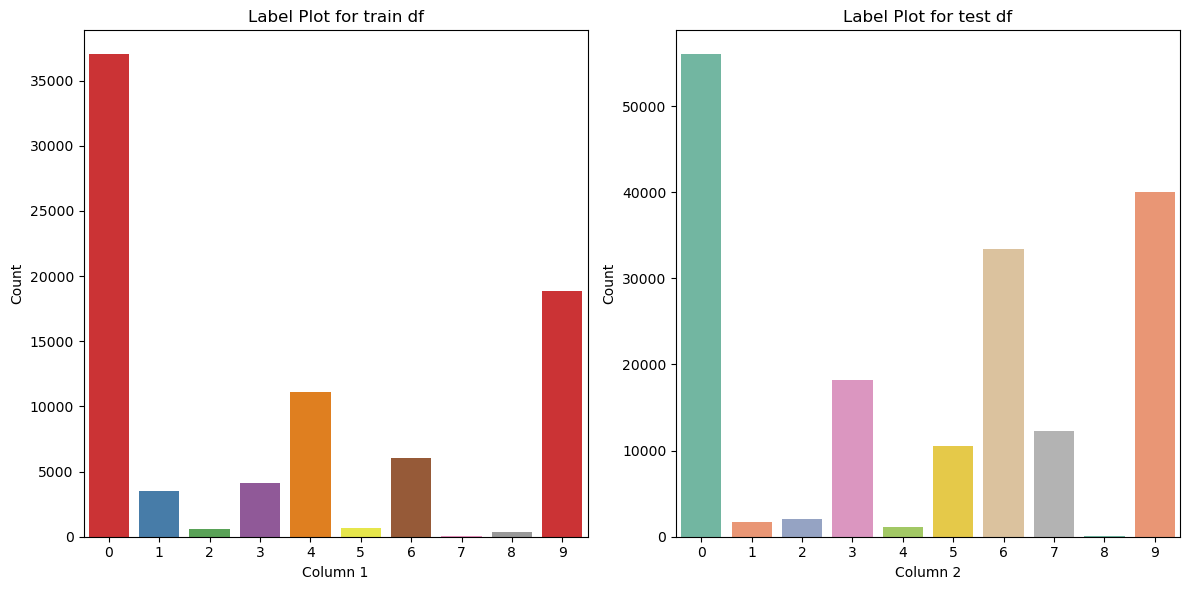

In [11]:
# Set up the figure with subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# Plot countplot for column1
sns.countplot(data=train_df, x='label', palette="Set1", ax=axes[0])
axes[0].set_title("Label Plot for train df")
axes[0].set_xlabel("Column 1")
axes[0].set_ylabel("Count")

# Plot countplot for column2
sns.countplot(data=test_df, x='label', palette="Set2", ax=axes[1])
axes[1].set_title("Label Plot for test df")
axes[1].set_xlabel("Column 2")
axes[1].set_ylabel("Count")

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()

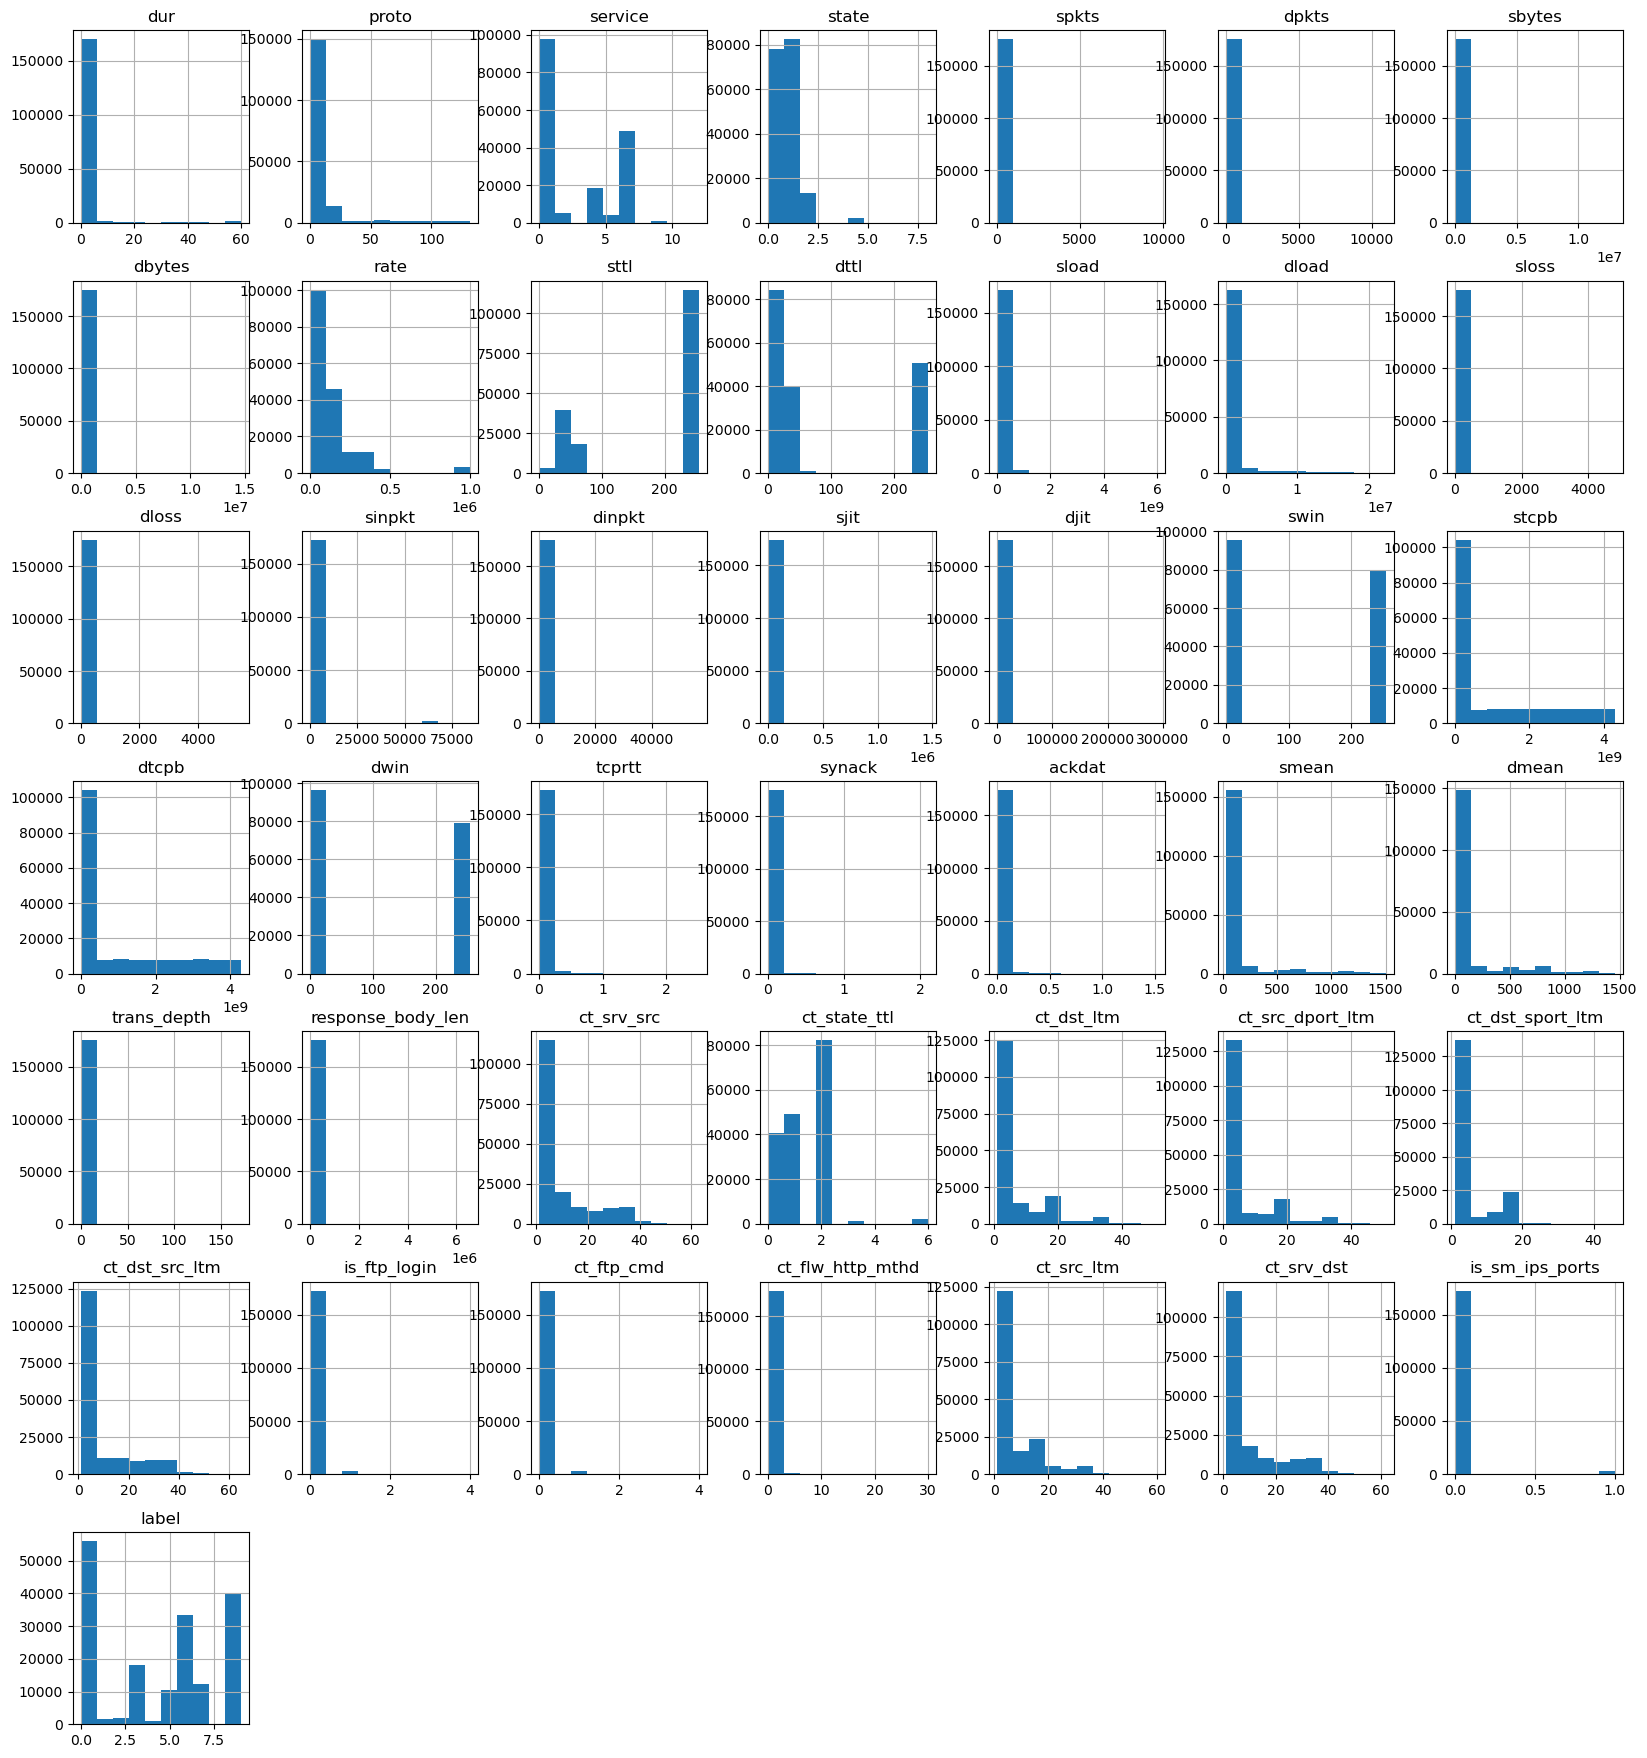

In [12]:
rcParams["figure.figsize"]=(20,22)
test_df.hist()
plt.grid()

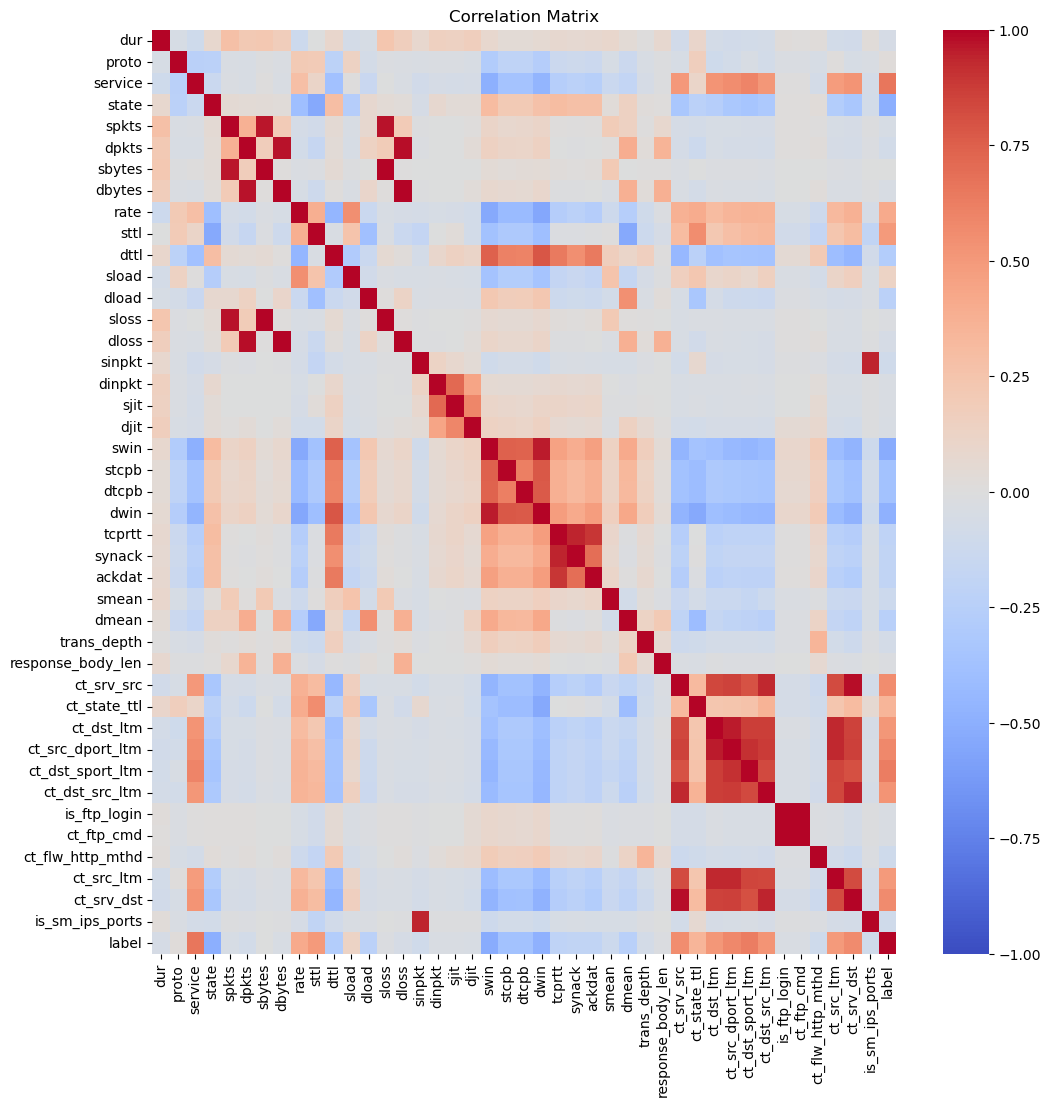

In [13]:
# Visualize - Correlation matrix

# Create a correlation matrix
corr_matrix = train_df.corr()

# Select the correlation values with 'label', label here means attack_cat
target_corr = corr_matrix['label']

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(12, 12))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show() 

In [14]:
# Show the feature ranking in corr order 

# Calculate the absolute correlation values with the 'label'
target_corr_abs = corr_matrix['label'].abs()

# Sort the correlation values in descending order
sorted_corr = target_corr_abs.sort_values(ascending=False)

# Print the sorted correlation values and their corresponding attributes
for attribute, correlation in target_corr_abs.items():
    print(f"{attribute}: {correlation:.4f}")

dur: 0.0569
proto: 0.0220
service: 0.6598
state: 0.5050
spkts: 0.0527
dpkts: 0.0784
sbytes: 0.0028
dbytes: 0.0435
rate: 0.4074
sttl: 0.4943
dttl: 0.2775
sload: 0.1251
dload: 0.2339
sloss: 0.0187
dloss: 0.0573
sinpkt: 0.1015
dinpkt: 0.0382
sjit: 0.0319
djit: 0.0455
swin: 0.5225
stcpb: 0.3723
dtcpb: 0.3734
dwin: 0.4849
tcprtt: 0.2084
synack: 0.1894
ackdat: 0.1953
smean: 0.1211
dmean: 0.2469
trans_depth: 0.0705
response_body_len: 0.0214
ct_srv_src: 0.5594
ct_state_ttl: 0.3439
ct_dst_ltm: 0.5083
ct_src_dport_ltm: 0.5819
ct_dst_sport_ltm: 0.6289
ct_dst_src_ltm: 0.5276
is_ftp_login: 0.0367
ct_ftp_cmd: 0.0371
ct_flw_http_mthd: 0.1064
ct_src_ltm: 0.4932
ct_srv_dst: 0.5681
is_sm_ips_ports: 0.0969
label: 1.0000


# Prepare the data

### Convert Pandas DF to Spark DF

In [15]:
sparktrain_df = spark.createDataFrame(train_df)
sparktest_df = spark.createDataFrame(test_df)

### Feature enabler

##### for Default

In [16]:
pipeline = SparkDFPipeline(standardize=True)
train, test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/15 16:52:03 WARN TaskSetManager: Stage 1 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:06 WARN TaskSetManager: Stage 7 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


In [17]:
train

23/08/15 16:52:07 WARN TaskSetManager: Stage 10 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:08 WARN TaskSetManager: Stage 13 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1565865302747...,4
[-0.2137265740846...,6
[-0.2137278478498...,4
[-0.0711011779642...,1
[-0.0712139061813...,1
[-0.2137280601440...,3
[-0.2137265740846...,6
[-0.0492389095628...,4
[0.03495866616626...,3
[-0.2137265740846...,4


In [18]:
test

23/08/15 16:52:08 WARN TaskSetManager: Stage 16 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:08 WARN TaskSetManager: Stage 17 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1910282644245...,0
[-0.1094844824357...,0
[0.04069910179508...,0
[0.04972853898095...,0
[-0.1404166278570...,0
[-0.1510515589413...,0
[-0.1114586350158...,0
[-0.1292858824805...,0
[-0.1259957310570...,0
[-0.1698548491691...,0


##### for Fine Tuning

In [19]:
pipeline = SparkDFPipeline(standardize=True)
FT_train, FT_test = pipeline.transform(sparktrain_df, sparktest_df)

23/08/15 16:52:08 WARN TaskSetManager: Stage 18 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:10 WARN TaskSetManager: Stage 24 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


In [20]:
FT_train

23/08/15 16:52:10 WARN TaskSetManager: Stage 27 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:11 WARN TaskSetManager: Stage 30 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1565865302747...,4
[-0.2137265740846...,6
[-0.2137278478498...,4
[-0.0711011779642...,1
[-0.0712139061813...,1
[-0.2137280601440...,3
[-0.2137265740846...,6
[-0.0492389095628...,4
[0.03495866616626...,3
[-0.2137265740846...,4


In [21]:
FT_test

23/08/15 16:52:11 WARN TaskSetManager: Stage 33 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:11 WARN TaskSetManager: Stage 34 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


features,label
[-0.1910282644245...,0
[-0.1094844824357...,0
[0.04069910179508...,0
[0.04972853898095...,0
[-0.1404166278570...,0
[-0.1510515589413...,0
[-0.1114586350158...,0
[-0.1292858824805...,0
[-0.1259957310570...,0
[-0.1698548491691...,0


# Model selection and training
- Select machine learning models (Logistic Regression , Decision Tree, Random Forest, Multilayer perceptron).
- Split the data into training and validation sets.
- Train the selected models using the training data.

## Logistic Regression model

### Default Model

In [22]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.01, elasticNetParam=0.8)

# Train the model
model = lr.fit(train)

# Make predictions on the test data
predictions = model.transform(test)

# Evaluate the model's performance
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print(f"Accuracy: {accuracy}")

23/08/15 16:52:11 WARN TaskSetManager: Stage 35 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:11 WARN TaskSetManager: Stage 36 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/08/15 16:52:23 WARN TaskSetManager: Stage 79 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:23 WARN TaskSetManager: Stage 80 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


Accuracy: 0.5286213720692822


In [23]:
# usage for default model
lr_default = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_default = Pipeline(stages=[lr_default])
model_default = pipeline_default.fit(train)  # Use the 'train' dataset

23/08/15 16:52:24 WARN TaskSetManager: Stage 82 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:25 WARN TaskSetManager: Stage 83 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:32 WARN TaskSetManager: Stage 120 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


###  Fine-Tuning 

In [24]:
# usage for fine-tuned models
lr_tuned = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)
pipeline_tuned = Pipeline(stages=[lr_tuned])
model_tuned = pipeline_tuned.fit(FT_train)  # Use the 'FT_train' dataset

23/08/15 16:52:32 WARN TaskSetManager: Stage 121 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:32 WARN TaskSetManager: Stage 122 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:39 WARN TaskSetManager: Stage 159 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


In [25]:
# Define the stages for your pipeline
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Create a pipeline with the defined stages
pipeline = Pipeline(stages=[lr])

# Define the ParamGrid
paramGrid = ParamGridBuilder() \
    .addGrid(lr.maxIter, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

# Instantiate CrossValidator with the pipeline and paramGrid
cv = CrossValidator(estimator=pipeline, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=3)

# Fit the CrossValidator on your training data
best_tuned_model = cv.fit(FT_train).bestModel



23/08/15 16:52:39 WARN TaskSetManager: Stage 160 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:52:45 WARN TaskSetManager: Stage 196 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:53:42 WARN TaskSetManager: Stage 589 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:53:47 WARN TaskSetManager: Stage 625 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:54:44 WARN TaskSetManager: Stage 1018 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:54:49 WARN TaskSetManager: Stage 1054 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:40 WARN TaskSetManager: Stage 1435 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 K

In [26]:
class_labels = train.select("label").toPandas()["label"]
print(class_labels)

23/08/15 16:55:54 WARN TaskSetManager: Stage 1534 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.


0        3
1        3
2        3
3        3
4        0
        ..
82327    0
82328    0
82329    0
82330    0
82331    0
Name: label, Length: 82332, dtype: int64


In [27]:
class_labels = ['Normal', 'Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode', 'Worms']

# Calculate class frequencies
class_frequencies = FT_train.groupBy("label").count()

# Calculate class weights
total_samples = FT_train.count()
class_frequencies = class_frequencies.withColumn("weight", total_samples / (class_frequencies["count"] * class_frequencies.count()))

# Join the weights with the training data
train_with_weights = FT_train.join(class_frequencies, on="label")

# Add a constant column for weight if it doesn't exist
if "weight" not in train_with_weights.columns:
    train_with_weights = train_with_weights.withColumn("weight", lit(1.0))

# Create a VectorAssembler
assembler = VectorAssembler(inputCols=['features'], outputCol='assembled_features')

# Define the Logistic Regression model with class weights
lr_weighted = LogisticRegression(featuresCol='assembled_features', labelCol='label', maxIter=10, weightCol='weight')

# Create a pipeline with the defined stages
pipeline_weighted = Pipeline(stages=[assembler, lr_weighted])

# Fit the pipeline on your training data with class weights
model_weighted = pipeline_weighted.fit(train_with_weights)


23/08/15 16:55:55 WARN TaskSetManager: Stage 1537 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:55 WARN TaskSetManager: Stage 1543 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:57 WARN TaskSetManager: Stage 1553 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:57 WARN TaskSetManager: Stage 1554 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:59 WARN TaskSetManager: Stage 1559 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:55:59 WARN TaskSetManager: Stage 1560 contains a task of very large size (1366 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:03 WARN TaskSetManager: Stage 1601 contains a task of very large size (1366 KiB). The maximum recommended task size is 10

### Evaluation

23/08/15 16:56:05 WARN TaskSetManager: Stage 1607 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:06 WARN TaskSetManager: Stage 1609 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:06 WARN TaskSetManager: Stage 1611 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:07 WARN TaskSetManager: Stage 1613 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:07 WARN TaskSetManager: Stage 1615 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:08 WARN TaskSetManager: Stage 1616 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


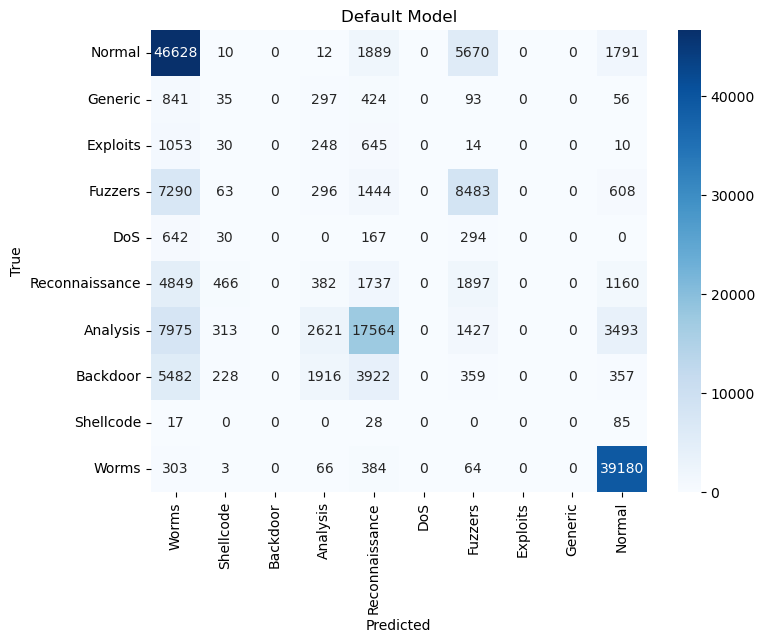

23/08/15 16:56:09 WARN TaskSetManager: Stage 1617 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:10 WARN TaskSetManager: Stage 1619 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:10 WARN TaskSetManager: Stage 1621 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:11 WARN TaskSetManager: Stage 1623 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:11 WARN TaskSetManager: Stage 1625 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:12 WARN TaskSetManager: Stage 1626 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


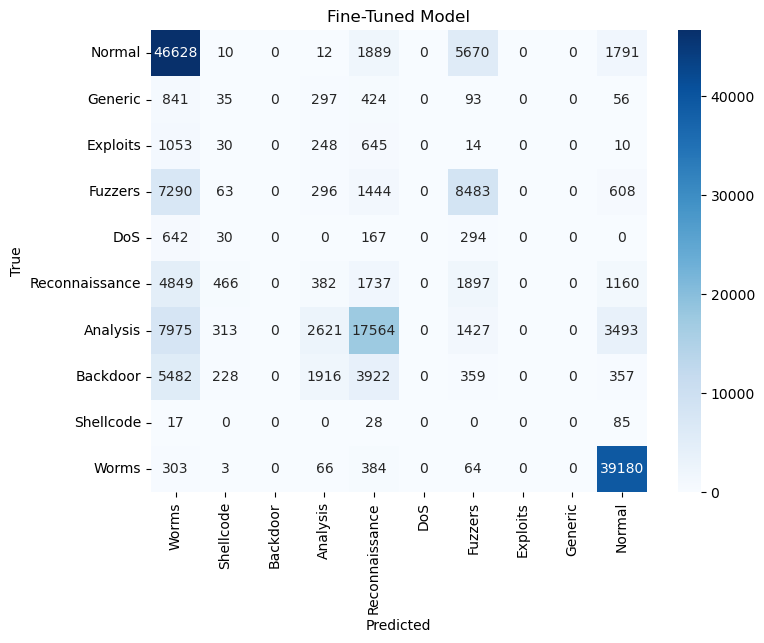

23/08/15 16:56:13 WARN TaskSetManager: Stage 1627 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:13 WARN TaskSetManager: Stage 1629 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:14 WARN TaskSetManager: Stage 1631 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:14 WARN TaskSetManager: Stage 1633 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:15 WARN TaskSetManager: Stage 1635 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:15 WARN TaskSetManager: Stage 1636 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


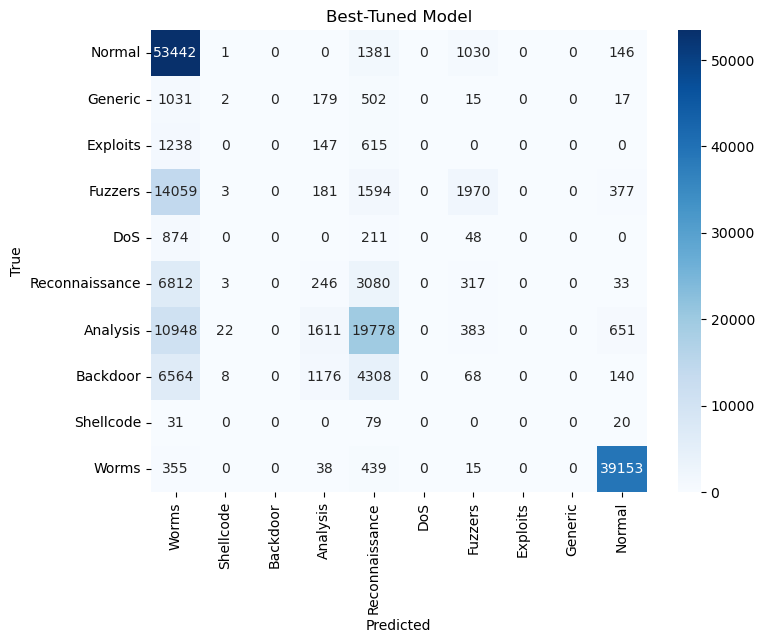

23/08/15 16:56:16 WARN TaskSetManager: Stage 1637 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:17 WARN TaskSetManager: Stage 1639 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:18 WARN TaskSetManager: Stage 1641 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:18 WARN TaskSetManager: Stage 1643 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:19 WARN TaskSetManager: Stage 1645 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.
23/08/15 16:56:20 WARN TaskSetManager: Stage 1646 contains a task of very large size (2970 KiB). The maximum recommended task size is 1000 KiB.


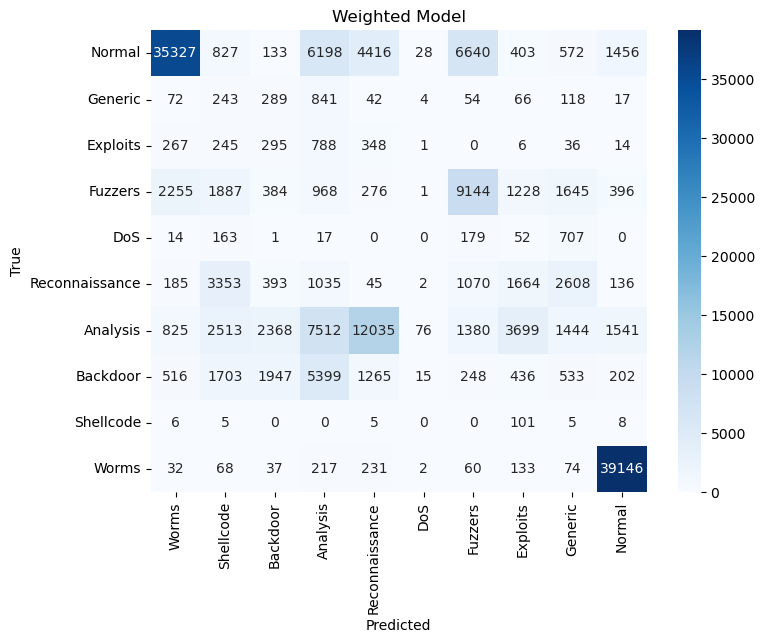

Evaluation Results:
Metric              Default Model       Fine-Tuned Model    Best-Tuned Model    Weighted Model      
Accuracy            0.500356            0.500356            0.532517            0.443718            
F1 Score            0.446689            0.446689            0.453095            0.470949            
Precision           0.410018            0.410018            0.424101            0.517738            
Recall              0.500356            0.500356            0.532517            0.443718            


In [28]:
# Evaluate models using the evaluate_model_multiclass function
evaluation_results_default = evaluate_model(model_default, test, 'Default Model')  # Use the 'test' dataset

# Evaluate models using the evaluate_model_multiclass function
evaluation_results_tuned = evaluate_model(model_tuned, FT_test, 'Fine-Tuned Model')  # Use the 'FT_test' dataset

# Corrected variable name
evaluation_results_best_tuned = evaluate_model(best_tuned_model, FT_test, 'Best-Tuned Model')  # Use the 'FT_test' dataset

evaluation_results_weighted = evaluate_model(model_weighted, FT_test, 'Weighted Model')  # Use the 'FT_test' dataset

# Print evaluation results for all models side by side
print("Evaluation Results:")
print(f"{'Metric':<20}{'Default Model':<20}{'Fine-Tuned Model':<20}{'Best-Tuned Model':<20}{'Weighted Model':<20}")
print("=" * 100)

for metric in evaluation_results_default.keys():
    default_value = evaluation_results_default[metric]
    tuned_value = evaluation_results_tuned[metric]
    best_tuned_value = evaluation_results_best_tuned[metric]
    weighted_value = evaluation_results_weighted[metric]
    print(f"{metric:<20}{default_value:<20.6f}{tuned_value:<20.6f}{best_tuned_value:<20.6f}{weighted_value:<20.6f}")


##### Sci-kit Learn

In [29]:
# from sklearn.metrics import confusion_matrix, classification_report

# def evaluate_model_with_visualization(model, val_data, model_name):
#     # Make predictions on the validation data
    # predictions = model.transform(val_data)

#     # Evaluate the model using a BinaryClassificationEvaluator for AUC
#     auc_evaluator = BinaryClassificationEvaluator(labelCol='label')
#     auc = auc_evaluator.evaluate(predictions)

#     # Calculate additional metrics
#     sensitivity = predictions.filter("label = 1 and prediction = 1").count() / predictions.filter("label = 1").count()
#     specificity = predictions.filter("label = 0 and prediction = 0").count() / predictions.filter("label = 0").count()
#     precision = predictions.filter("prediction = 1").count() / predictions.filter("prediction = 1 or prediction = 0").count()
#     recall = sensitivity
#     f1_score = 2 * (precision * recall) / (precision + recall)
#     accuracy = (predictions.filter("label = prediction").count()) / predictions.count()

#     # Convert Spark DataFrames to Pandas DataFrames for visualization
#     y_true_pd = predictions.select('label').toPandas()
#     y_pred_pd = predictions.select('prediction', 'probability').toPandas()
    
#     # Convert prediction probabilities to binary predictions
#     y_pred_binary = [1 if prob[1] >= 0.5 else 0 for prob in y_pred_pd['probability']]

#     # Generate the confusion matrix
#     cm = confusion_matrix(y_true_pd['label'], y_pred_binary)

#     # Display the confusion matrix as a heatmap
#     plt.figure(figsize=(6, 4))
#     sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-default', 'Default'], 
#                 yticklabels=['Non-default', 'Default'])
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title(model_name)
#     plt.show()

#     # Generate the classification report
#     report = classification_report(y_true_pd['label'], y_pred_binary, target_names=['Non-default', 'Default'], output_dict=True)

#     # Create a summary table
#     summary_table = pd.DataFrame({
#         'Model': [model_name],
#         'AUC': [auc],
#         'Sensitivity': [sensitivity],
#         'Specificity': [specificity],
#         'Precision': [precision],
#         'Recall': [recall],
#         'F1-Score': [f1_score],
#         'Accuracy': [accuracy],
#         'Precision (Non-default)': [report['Non-default']['precision']],
#         'Recall (Non-default)': [report['Non-default']['recall']],
#         'F1-score (Non-default)': [report['Non-default']['f1-score']],
#         'Precision (Default)': [report['Default']['precision']],
#         'Recall (Default)': [report['Default']['recall']],
#         'F1-score (Default)': [report['Default']['f1-score']],
#     })

#     return summary_table

# # Assuming you have 'model_default' and 'test' DataFrame from your pipeline
# evaluation_results_default = evaluate_model_with_visualization(model_default, test, 'Default Model')
# print(evaluation_results_default)


In [30]:
# from sklearn.metrics import confusion_matrix

# # Assuming you have the true labels and predicted labels for your test data
# true_labels = test.select('label').rdd.flatMap(lambda x: x).collect()
# predicted_labels = model_default.transform(test).select('prediction').rdd.flatMap(lambda x: x).collect()

# # Calculate the confusion matrix
# cm = confusion_matrix(true_labels, predicted_labels)

# # Print the confusion matrix
# print("Confusion Matrix:")
# print(cm)

## Decision Tree Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Random Forest Model

### Default Model

###  Fine-Tuning 

### Evaluation

## Multilayer perceptron Model

### Default Model

###  Fine-Tuning 

### Evaluation

# Final comparison between Models